### Import Liberary

In [1]:
from math import pow, sqrt, cos, sin, pi, degrees, radians, atan2
import numpy as np
import matplotlib.pyplot as Plot
from mpl_toolkits.mplot3d import Axes3D
import time
from itertools import count
from ipywidgets import interact, fixed

### Input

In [2]:
n = 4 # No of joints

# DH Parameters
alpha = np.array([0,pi/2,0,0])   
a = np.array([0,0,0.1302305,0.124])
d = np.array([0.077,0,0,0])
theta = np.array([0,1.38544838,-1.38544838,0])
#le = 0.126
le = 0.138

# Off-set
p = 0.128
q = 0.024

l1 = 0.077   # link-1 length
l2 = sqrt(pow(p,2) + pow(q,2))   # link-2 length
l3 = 0.124   # link-3 length

### Transformation Matrix

In [3]:
def transformation_matrix(n,alpha,a,d,theta):
    I = np.eye(4)
    R = np.zeros((n,3,3))
    O = np.zeros((3,n))

    # Transformation Matrix
    for i in range(0,n):
        T = np.array([[    cos(theta[i])        ,        -sin(theta[i])      ,        0      ,         a[i]       ],
                    [sin(theta[i])*cos(alpha[i]), cos(theta[i])*cos(alpha[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])],                                               
                    [sin(theta[i])*sin(alpha[i]), cos(theta[i])*sin(alpha[i]),  cos(alpha[i]),  d[i]*cos(alpha[i])],     
                    [             0             ,              0             ,        0      ,           1        ]])

        T_new = np.dot(I,T)
        R[i,:,:] = T_new[0:3,0:3]
        O[0:3,i] = T_new[0:3,3]
        I = T_new
        i= i + 1

    T_final = I
    d_nn = np.array([[0.138],[0],[0],[1]])
    P_00_home = np.dot(T_final,d_nn)
    P_00 = P_00_home[0:3]
    
    return(P_00, R,O)

### Jacobain Matrix

In [4]:
def jacobian_matrix(n,alpha,a,d,theta,le):
    (P_00, R, O) = transformation_matrix(n,alpha,a,d,theta)

    R_n_0 = R[n-1,:,:]
    O_n_0 = np.transpose(np.array([O[:,n-1]]))
    O_E_n = np.array([[le],[0],[0]])
    O_E = O_n_0 + np.dot(R_n_0,O_E_n)

    Jz = np.zeros((3,n))
    Jw = np.zeros((3,n))

    for i in range(0,n):
        Z_i_0 = np.transpose(np.array([R[i,:,2]]))
        O_i_0 = np.transpose(np.array([O[:,i]]))
        O_E_i_0 = O_E - O_i_0

        cross_prod = np.cross(Z_i_0,O_E_i_0,axis=0)
        Jz[:,i] = np.reshape(cross_prod,(3,)) # conver 2D of shape (3,1) to 1D of shape (3,)
        Jw[:,i] = np.reshape(Z_i_0,(3,)) # conver 2D of shape (3,1) to 1D of shape (3,)

    J = np.concatenate((Jz,Jw),axis=0)
    return J

### Forward Kinematics

In [5]:
def forward_kinematics(n,alpha,a,d,theta,le):
    I = np.eye(4)
    R = np.zeros((n,3,3))
    O = np.zeros((3,n))

    # Transformation Matrix
    for i in range(0,n):
        T = np.array([[    cos(theta[i])        ,        -sin(theta[i])      ,        0      ,         a[i]       ],
                    [sin(theta[i])*cos(alpha[i]), cos(theta[i])*cos(alpha[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])],                                               
                    [sin(theta[i])*sin(alpha[i]), cos(theta[i])*sin(alpha[i]),  cos(alpha[i]),  d[i]*cos(alpha[i])],     
                    [             0             ,              0             ,        0      ,           1        ]])

        T_new = np.dot(I,T)
        R[i,:,:] = T_new[0:3,0:3]
        O[0:3,i] = T_new[0:3,3]
        I = T_new
        i= i + 1

    T_final = I
    d_nn = np.array([[le],[0],[0],[1]])
    P_00_home = np.dot(T_final,d_nn)
    P_00 = P_00_home[0:3]

    X_cord = np.array([0,O[0,0],O[0,1],O[0,2],O[0,3],P_00[0,0]])
    Y_cord = np.array([0,O[1,0],O[1,1],O[1,2],O[1,3],P_00[1,0]])
    Z_cord = np.array([0,O[2,0],O[2,1],O[2,2],O[2,3],P_00[2,0]])

    return(X_cord,Y_cord,Z_cord)

    #return P_00


### Static Plot Forward Kinematics

(0, 0.25)

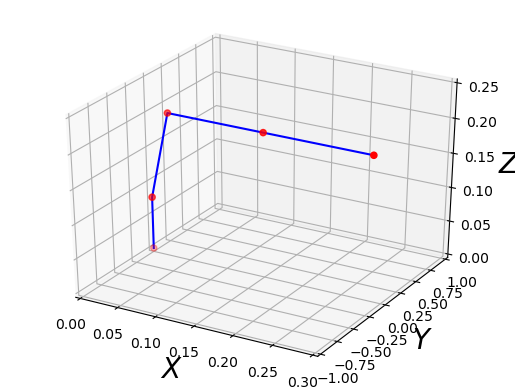

In [6]:
(X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,theta,le)

# Plot
fig_1 = Plot.figure()
axis_object_1 = Plot.axes(projection ='3d')
axis_object_1.scatter(X_cord,Y_cord,Z_cord,c='Red')
axis_object_1.plot(X_cord,Y_cord,Z_cord,c='blue')

# Axis Label
axis_object_1.set_xlabel('$X$',fontsize=20)
axis_object_1.set_ylabel('$Y$',fontsize=20)
axis_object_1.set_zlabel('$Z$',fontsize=20)

# Axis Limit
axis_object_1.axes.set_xlim3d(left=0, right=0.3) 
axis_object_1.axes.set_ylim3d(bottom=-1, top=1) 
axis_object_1.axes.set_zlim3d(bottom=0, top=0.25)

### Forward Kinematics Plot with Slider 

In [7]:
def plot_robot(theta1, theta2, theta3, theta4):
    theta = np.hstack((theta1,theta2,theta3,theta4))
    # Compute the end-effector position
    (X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,theta,le)
    
    # Plot the robot's links
    Plot.axes(projection ='3d')
    
    # Plot the end-effector position
    axis_object_1 = Plot.axes(projection ='3d')
    axis_object_1.scatter(X_cord,Y_cord,Z_cord,c='Red')
    axis_object_1.plot(X_cord,Y_cord,Z_cord,c='blue')
    
    # Axis Label
    axis_object_1.set_xlabel('$X$',fontsize=15)
    axis_object_1.set_ylabel('$Y$',fontsize=15)
    axis_object_1.set_zlabel('$Z$',fontsize=15)
    
    # Axis Limit
    axis_object_1.axes.set_xlim3d(left=-0.2, right=0.2) 
    axis_object_1.axes.set_ylim3d(bottom=-1, top=1) 
    axis_object_1.axes.set_zlim3d(bottom=0, top=0.25)

    # Show the plot
    Plot.show()

# Use the interact function to create sliders for controlling the joint angles, and call the plot_robot function with the current values of the sliders
interact(plot_robot, theta1=(-np.pi, np.pi), theta2=(-np.pi, np.pi), theta3=(-np.pi, np.pi), theta4=(-np.pi, np.pi))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=3.141592653589793, min=-3.1415926535897…

<function __main__.plot_robot(theta1, theta2, theta3, theta4)>

### Forward Kinematics Animation
##### After running this section run **FK_animation.py** file, to see the animation

In [8]:
theta = np.transpose(np.array([np.linspace(0,0,50),np.linspace(1.38544838,0.698132,50),np.linspace(-1.38544838,0,50),np.linspace(0,1.38544838,50)]))
row,column = theta.shape

for j in range(0,row):
    I = np.eye(4)
    R = np.zeros((n,3,3))
    O = np.zeros((3,n))

    # Transformation Matrix
    for i in range(0,n):
        T = np.array([[          round(cos(theta[j,i]),5)           ,           -round(sin(theta[j,i]),5)            ,             0          ,              a[i]           ],
                    [round(sin(theta[j,i]),5)*round(cos(alpha[i]),5), round(cos(theta[j,i]),5)*round(cos(alpha[i]),5), -round(sin(alpha[i]),5), -d[i]*round(sin(alpha[i]),5)],                                               
                    [round(sin(theta[j,i]),5)*round(sin(alpha[i]),5), round(cos(theta[j,i]),5)*round(sin(alpha[i]),5),  round(cos(alpha[i]),5),  d[i]*round(cos(alpha[i]),5)],     
                    [                      0                        ,                       0                        ,             0          ,                1            ]])

        T_new = np.dot(I,T)
        R[i,:,:] = T_new[0:3,0:3]
        O[0:3,i] = T_new[0:3,3]
        I = T_new
        i= i + 1

    T_final = I
    d_nn = np.array([[le],[0],[0],[1]])
    P_00_home = np.dot(T_final,d_nn)
    P_00 = P_00_home[0:3]

    if j == 0:
        X_cord = np.array([0,O[0,0],O[0,1],O[0,2],O[0,3],P_00[0,0]])
        Y_cord = np.array([0,O[1,0],O[1,1],O[1,2],O[1,3],P_00[1,0]])
        Z_cord = np.array([0,O[2,0],O[2,1],O[2,2],O[2,3],P_00[2,0]])
    else:
        X_cord = np.vstack((X_cord,np.array([0,O[0,0],O[0,1],O[0,2],O[0,3],P_00[0,0]])))
        Y_cord = np.vstack((Y_cord,np.array([0,O[1,0],O[1,1],O[1,2],O[1,3],P_00[1,0]])))
        Z_cord = np.vstack((Z_cord,np.array([0,O[2,0],O[2,1],O[2,2],O[2,3],P_00[2,0]])))   

FK_Data = np.hstack([X_cord,Y_cord,Z_cord])
file = open("FK_Data", "wb")
np.save(file,FK_Data)
file.close

<function BufferedWriter.close>

### Inverse Kinematics using Analitical Method

Joint angle in degree:  0.0 , 79.38 , -79.38 , 0.0


(0.0, 0.25)

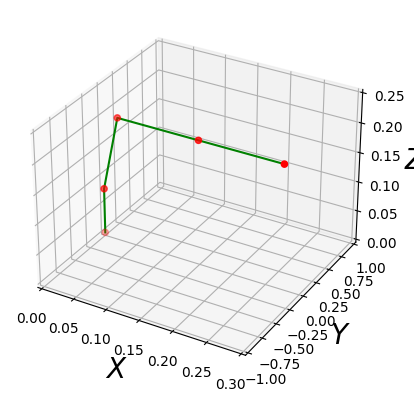

In [9]:
# End effector Coordinates
Px = 0.274
Py = 0
Pz = 0.205
phi = radians(0)
O_E_0 = np.array([[Px],[Py],[Pz]])

# calculate theta1
th1 = atan2(Py,Px)

# O_4_0 Coordinates
R_4_0 = np.array([[cos(phi), -sin(phi), 0],[sin(phi), cos(phi), 0],[0, 0, 1]])
d_n_n = np.array([[0.126],[0],[0]])
O_4_0 = O_E_0 - np.dot(R_4_0,d_n_n)

# O_1_0 Coordinates
O_1_0 = np.array([[0],[0],[l1]])

# calculate theta3
D1 = sqrt(pow((O_4_0[0] - O_1_0[0]),2) + pow((O_4_0[1] - O_1_0[1]),2) + pow((O_4_0[2] - O_1_0[2]),2))
cos_psi = (pow(l3,2) + pow(l2,2) - pow(D1,2))/(2*l2*l3)
sin_psi = sqrt(1 - pow(cos_psi,2))

psi = atan2(sin_psi,cos_psi)
th3 = -pi + psi

# calculate theta2theta1
cos_gamma = (pow(l2,2) + pow(D1,2) - pow(l3,2))/(2*l2*D1)
sin_gamma = sqrt(1-pow(cos_gamma,2))

gamma = atan2(sin_gamma,cos_gamma)
beta = atan2((O_4_0[2] - O_1_0[2]),sqrt(pow(O_4_0[0], 2) + pow(O_4_0[1], 2)))
th2 = gamma + beta

# calculate theta4
th4 = phi - th2 - th3

# DH-parameters
alpha = np.array([0,pi/2,0,0])   
a = np.array([0,0,sqrt(pow(p,2) + pow(q,2)),0.124])
d = np.array([0.077,0,0,0])
theta = np.array([th1,th2,th3,th4])

print('Joint angle in degree: ',round(degrees(th1),3),',',round(degrees(th2),3),',',round(degrees(th3),3),',',round(degrees(th4),3)) # Print Joint angles in degree

I = np.eye(4)
R = np.zeros((n,3,3))
O = np.zeros((3,n))

# Transformation Matrix
for i in range(0,n):
    T = np.array([[            round(cos(theta[i]),5)           ,            -round(sin(theta[i]),5)           ,             0          ,             a[i]            ],
                  [round(sin(theta[i]),5)*round(cos(alpha[i]),5), round(cos(theta[i]),5)*round(cos(alpha[i]),5), -round(sin(alpha[i]),5), -d[i]*round(sin(alpha[i]),5)],                                               
                  [round(sin(theta[i]),5)*round(sin(alpha[i]),5), round(cos(theta[i]),5)*round(sin(alpha[i]),5),  round(cos(alpha[i]),5),  d[i]*round(cos(alpha[i]),5)],     
                  [                      0                      ,                       0                      ,             0          ,               1             ]])

    T_new = np.dot(I,T)
    R[i,:,:] = T_new[0:3,0:3]
    O[0:3,i] = T_new[0:3,3]
    I = T_new
    i= i + 1

# O_3_0 coordinates
R_3_0 = R[2,:,:]
d_3_3 = np.array([[l3],[0],[0]])
O_3_0 = O_4_0 - np.dot(R_3_0,d_3_3)

# O_2_0 coordinates
R_2_0 = R[1,:,:]
d_2_2 = np.array([[l2],[0],[0]])
O_2_0 = O_3_0 - np.dot(R_2_0,d_2_2)

# Plot
X_cord = np.array([0,O_1_0[0,0],O_2_0[0,0],O_3_0[0,0],O_4_0[0,0],Px])
Y_cord = np.array([0,O_1_0[1,0],O_2_0[1,0],O_3_0[1,0],O_4_0[1,0],Py])
Z_cord = np.array([0,O_1_0[2,0],O_2_0[2,0],O_3_0[2,0],O_4_0[2,0],Pz])

# Plot Manipulator
fig_2 = Plot.figure()
axis_object_2 = Plot.axes(projection ='3d')
axis_object_2.plot(X_cord,Y_cord,Z_cord,c = "g")
axis_object_2.scatter(X_cord,Y_cord,Z_cord,c = "r")

# Axis Label
axis_object_2.set_xlabel('$X$',fontsize=20)
axis_object_2.set_ylabel('$Y$',fontsize=20)
axis_object_2.set_zlabel('$Z$',fontsize=20)

# Axis Limit
axis_object_2.axes.set_xlim3d(left=0, right=0.3) 
axis_object_2.axes.set_ylim3d(bottom=-1, top=1) 
axis_object_2.axes.set_zlim3d(bottom=0, top=0.25)


## Inverse Jacobian based Control
#### link : https://www.rosroboticslearning.com/jacobian

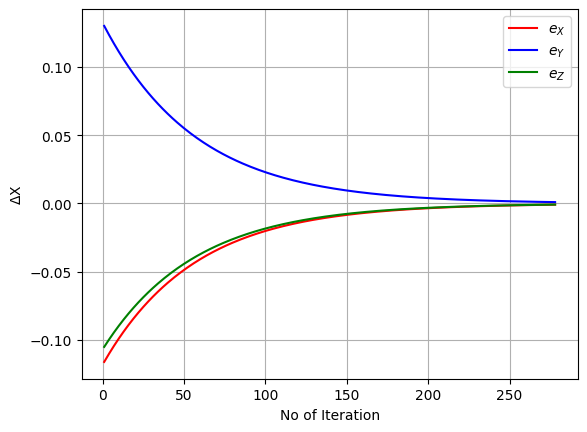

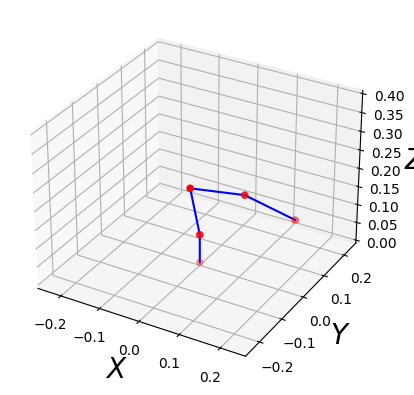

In [12]:
goal_X, goal_Y, goal_Z = 0.17, 0.13, 0.1

i = 0

q = np.reshape(theta,(1,4))

(X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,q[i,:],le)

X = np.reshape(X_cord,(1,6))
Y = np.reshape(Y_cord,(1,6))
Z = np.reshape(Z_cord,(1,6))

del_X = np.ones((3,1))
while np.max(np.abs(del_X[0:3,i])) > 0.001:
    X_c = X[i,n+1]
    Y_c = Y[i,n+1]
    Z_c = Z[i,n+1]

    del_X = np.hstack((del_X, np.array([[goal_X - X_c],[goal_Y - Y_c],[goal_Z - Z_c]])))

    J = jacobian_matrix(n,alpha,a,d,q[i,:],le)
    Jv_pseudo = np.round(np.linalg.pinv(J[0:3,:]),5)

    q_new = np.degrees(q[i,:]) + np.reshape(np.dot(Jv_pseudo,del_X[:,i+1]),(4,))
    q = np.vstack((q,np.radians(q_new)))

    (X_cord,Y_cord,Z_cord) = forward_kinematics(n,alpha,a,d,q[i+1,:],le)

    i = i + 1

    X = np.vstack((X, np.reshape(X_cord,(1,6))))
    Y = np.vstack((Y, np.reshape(Y_cord,(1,6))))
    Z = np.vstack((Z, np.reshape(Z_cord,(1,6))))

fig_3 = Plot.figure()
(Row,Column) = del_X.shape

Plot.plot(range(1,Column),del_X[0,1:Column], 'r-')
Plot.plot(range(1,Column),del_X[1,1:Column], 'b-')
Plot.plot(range(1,Column),del_X[2,1:Column], 'g-')

Plot.xlabel('No of Iteration')
Plot.ylabel('$\Delta$X')
Plot.legend(['$e_{X}$','$e_{Y}$','$e_{Z}$'])
Plot.grid()

Plot.show()

fig_4 = Plot.figure()
axis_object_4 = Plot.axes(projection ='3d')

# Axis Label
axis_object_4.set_xlabel('$X$',fontsize=20)
axis_object_4.set_ylabel('$Y$',fontsize=20)
axis_object_4.set_zlabel('$Z$',fontsize=20)

# Axis Limit
axis_object_4.axes.set_xlim3d(left=-0.25, right=0.25) 
axis_object_4.axes.set_ylim3d(bottom=-0.25, top=0.25) 
axis_object_4.axes.set_zlim3d(bottom=0, top=0.4)

axis_object_4.scatter(X[i,:],Y[i,:],Z[i,:],c='Red')
axis_object_4.plot(X[i,:],Y[i,:],Z[i,:],c='blue')
Plot.show()

### Weight Function

In [29]:
def weight_Func(m,n,q_range,q,epsilon):
    We = np.zeros((m,m))
    for i in range(0,m):
        We[i,i] = 5

    Wc = np.zeros((n,n))
    for i in range(0,n):
        if q[0,i] < q_range[i,0]:
            Wc[i,i] = 100
        elif q_range[i,0] <= q[0,i] <= (q_range[i,0] + epsilon[0,i]):
            Wc[i,i] = (100/2)*(1 + cos(pi*((q[0,i] - q_range[i,0])/epsilon[0,i])))
        elif (q_range[i,0] + epsilon[0,i]) < q[0,i] < (q_range[i,1] - epsilon[0,i]):
            Wc[i,i] = 0
        elif (q_range[i,1] - epsilon[0,i]) <= q[0,i] <= q_range[i,1]:
            Wc[i,i] = (100/2)*(1 + cos(pi*((q_range[i,1] - q[0,i])/epsilon[0,i])))
        else:
            Wc[i,i] = 100

    Wv = np.zeros((n,n))
    for i in range(0,n):
        Wv[i,i] = 0.5
    
    return We, Wc, Wv

In [30]:
goal_Px, goal_Py, goal_Pz = 0.17, -0.13, 0.075 #0.17, 0.13, 0.1
i = 0
q = np.array([[0,0,0,0]]) # Hardware & Gazebo Joint Angle at Home Position

joint_offset = np.array([[0,1.38544838,-1.38544838,0]]) 
theta = q + joint_offset # Initial Joint position as per DH convention

Jc = np.eye((n))
q_range = np.radians(np.array([[-180,180],[-117,90],[-90,87.5],[-103,114.5]]))
epsilon = 0.5*np.ones(q.shape) # Activation buffer

del_X = np.ones((3,1)) # defining an array to start the loop
while np.max(np.abs(del_X[:,i])) > 0.001:
    # if i == 20:
    #     break
    # else:
    #     pass

    if q_range[0,0] > q[0,0] or q[0,0] > q_range[0,1]:
        print('Joint 1 Limit breached')
        break
    elif q_range[1,0] > q[0,1] or q[0,1] > q_range[1,1]:
        print('Joint 2 Limit breached')
        break
    elif q_range[2,0] > q[0,2] or q[0,2] > q_range[2,1]:
        print('Joint 3 Limit breached')
        break
    elif q_range[3,0] > q[0,3] or q[0,3] > q_range[3,1]:
        print('Joint 4 Limit breached')
        break
    else:
        pass  

    if i == 0:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:],le)   # Forward Kinematics
        X,Y,Z = X_cord,Y_cord,Z_cord
    else:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:],le)   # Forward Kinematics
        X = np.vstack((X,X_cord))
        Y = np.vstack((Y,Y_cord))
        Z = np.vstack((Z,Z_cord))

    Px, Py, Pz = X_cord[5],Y_cord[5],Z_cord[5]
    #print('Coord: ',Px,',',Py,',',Pz,'\n')

    We, Wc, Wv = weight_Func(3,n,q_range,q,epsilon)

    # Newton Raphson Mathod
    del_X = np.hstack((del_X, np.array([[goal_Px - Px],[goal_Py - Py],[goal_Pz - Pz]])))
    #print('del_X: ',del_X[:,i+1],'\n')
    
    J = jacobian_matrix(n,alpha,a,d,theta[i,:],le)  # Calculate J
    Je = J[0:3,:]
    Jn = np.linalg.inv(np.transpose(Je) @ We @ Je + np.transpose(Jc) @ Wc @ Jc + Wv) @ np.transpose(Je) @ We

    theta_new = np.degrees(theta[i,:]) + np.reshape(np.dot(Jn,del_X[:,i+1]),(4,)) # In degrees
    q = np.radians(theta_new) - joint_offset # In radians
    #print('******************************************************************','\n')
    theta = np.vstack((theta,np.radians(theta_new))) # In radians

    i = i + 1

# IK_Data_JLA_1 = np.hstack([X,Y,Z])
# file = open("IK_Data_JLA_1", "wb")
# np.save(file,IK_Data_JLA_1)
# file.close

3 2315


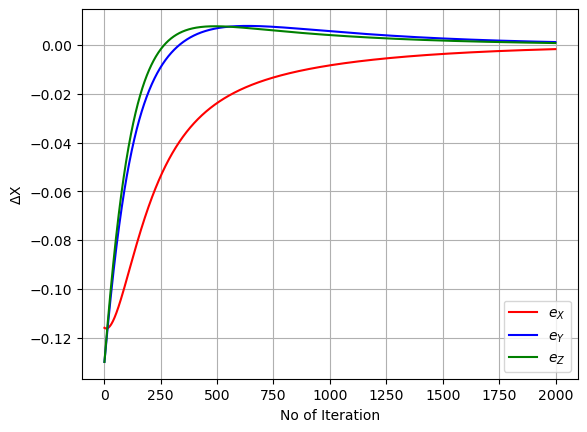

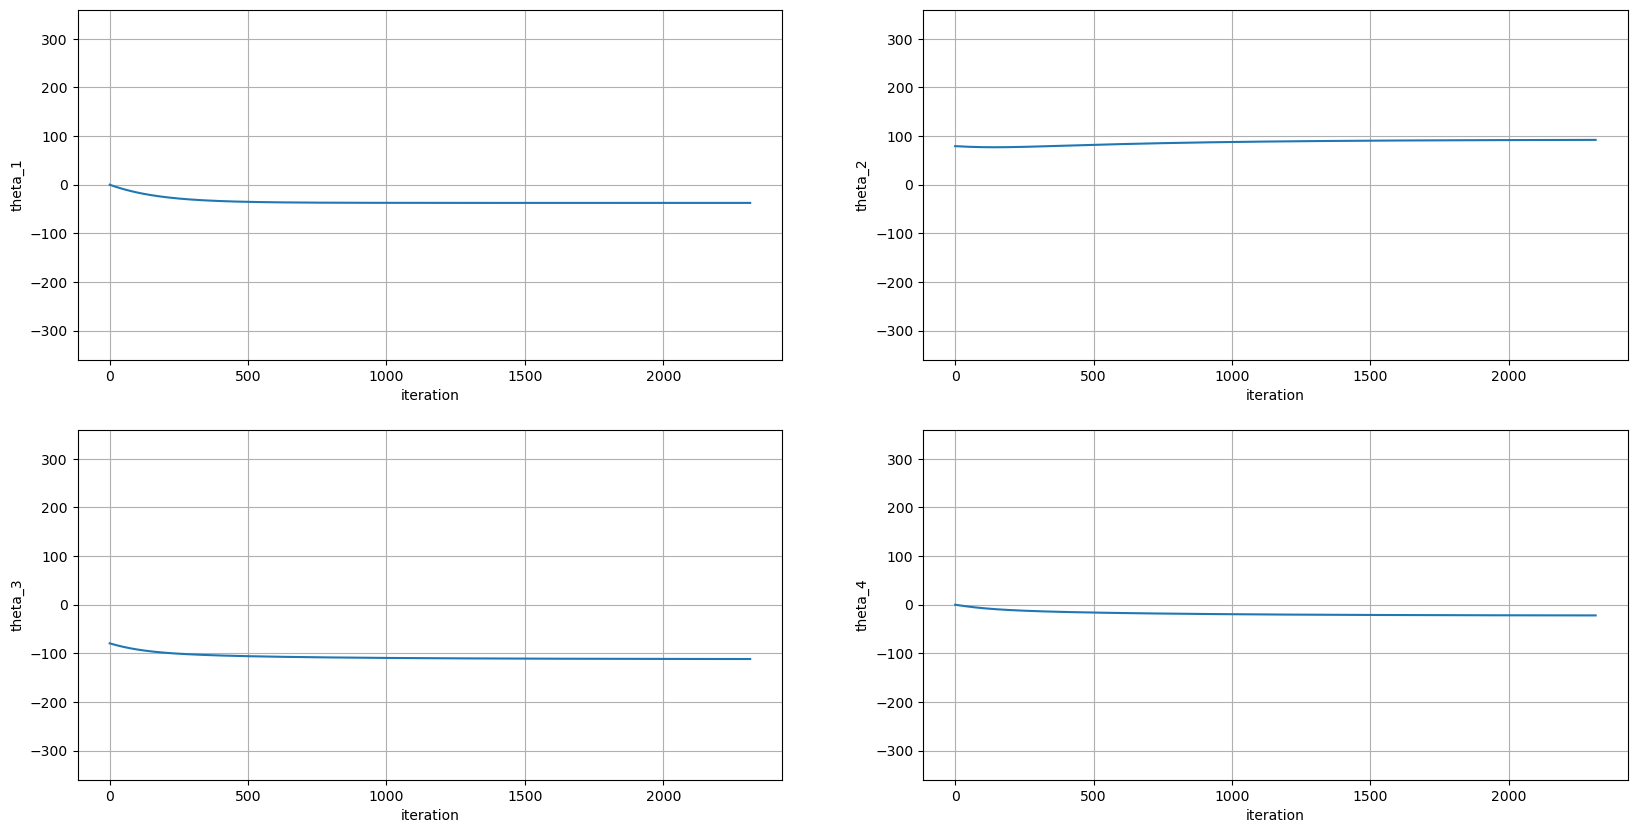

In [32]:
(Row,Column) = del_X.shape
print(Row,Column)
fig_5 = Plot.figure()
asp = 2000

# Plot.plot(range(1,Column),del_X[0,1:Column], 'r-')
# Plot.plot(range(1,Column),del_X[1,1:Column], 'b-')
# Plot.plot(range(1,Column),del_X[2,1:Column], 'g-')
Plot.plot(range(1,asp),del_X[0,1:asp], 'r-')
Plot.plot(range(1,asp),del_X[1,1:asp], 'b-')
Plot.plot(range(1,asp),del_X[2,1:asp], 'g-')

Plot.xlabel('No of Iteration')
Plot.ylabel('$\Delta$X')
Plot.legend(['$e_{X}$','$e_{Y}$','$e_{Z}$'])
Plot.grid()

Plot.show()

# Now plot the data
joints = ['theta_1','theta_2','theta_3','theta_4']
Plot.figure(figsize=(20,10))
#Plot.tight_layout(pad=3.0) # give some spacing btw two subplots
for i in range(1,n+1):
    ax = Plot.subplot(2,2,i) # math.ceil() will round the value to upper limit
    Plot.plot(range(0,Column), np.degrees(theta[:,i-1]))
    Plot.ylim(-360,360)
    Plot.grid()
    # ax.set_aspect('No set_aspect')
    Plot.ylabel(joints[i-1])
    Plot.xlabel('iteration')
Plot.show()

### Cost Function

In [6]:
# Initiate
c = np.zeros((n,))
b = np.zeros((n,))
del_phi_del_q = np.zeros((n,))

In [7]:
def cost_func(n,K,q,q_range,m):
    q_c = np.mean(q_range,axis = 1); # column vector containing the mean of each row
    del_q = q_range[:,1] - q_range[:,0]; # Total working range of each joint

    for i in range(0,n):
        if q[0,i] >= q_c[i]:
            c[i] = pow((K[i,i]*((q[0,i] - q_c[i])/del_q[i])),m)
            b[i] = pow((K[i,i]*((q[0,i] - q_c[i])/del_q[i])),m-1)
        elif q[0,i] < q_c[i]:
            c[i] = pow((K[i,i]*((q_c[i] - q[0,i])/del_q[i])),m)
            b[i] = pow((K[i,i]*((q_c[i] - q[0,i])/del_q[i])),(m-1))

    L = np.sum(c)

    for j in range(0,n):
        if q[0,j] >= q_c[j]:
            del_phi_del_q[j] = pow(L,((1-m)/m))*b[j]*(K[j,j]/del_q[j])
        elif q[0,j] < q_c[j]:
            del_phi_del_q[j] = -pow(L,((1-m)/m))*b[j]*(K[j,j]/del_q[j])

    v = -del_phi_del_q
    return v

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


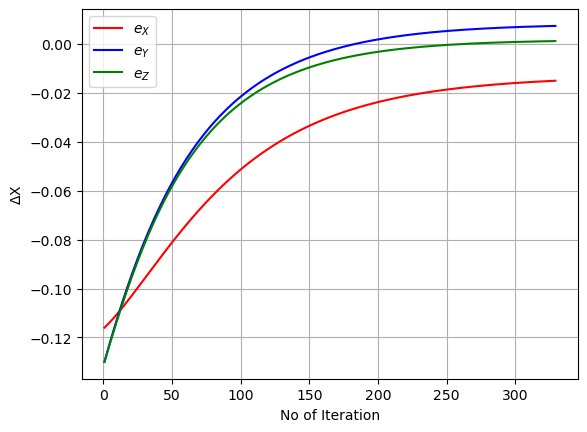

In [12]:
goal_Px, goal_Py, goal_Pz = 0.17, -0.13, 0.075 #0.17, 0.13, 0.1
i = 0
q = np.array([[0,0,0,0]]) # Hardware & Gazebo Joint Angle at Home Position

joint_offset = np.array([[0,1.38544838,-1.38544838,0]])  # Joint angle offset in hardware
theta = q + joint_offset # Initial Joint position as per DH convention
q_range = np.radians(np.array([[-180,180],[-117,90],[-90,87.5],[-103,114.5]])) # range of motion of each joint

m = 5 # mth norm of a vector
Lambda = 0.1 # weights for Singularity avoidance
K = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # In some practical cases, avoiding joint limit is more important for certain joints, in such cases a weight matrix K is multiplied to the mth norm.

del_X = np.ones((3,1)) # defining an array to start the loop
while np.max(np.abs(del_X[:,i])) > 0.015:

    if q_range[0,0] > q[0,0] or q[0,0] > q_range[0,1]:
        print('Joint 1 Limit breached')
        break
    elif q_range[1,0] > q[0,1] or q[0,1] > q_range[1,1]:
        print('Joint 2 Limit breached')
        break
    elif q_range[2,0] > q[0,2] or q[0,2] > q_range[2,1]:
        print('Joint 3 Limit breached')
        break
    elif q_range[3,0] > q[0,3] or q[0,3] > q_range[3,1]:
        print('Joint 4 Limit breached')
        break
    else:
        pass  

    if i == 0:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:],le)  # Forward Kinematics
        X,Y,Z = X_cord,Y_cord,Z_cord
    else:
        X_cord,Y_cord,Z_cord = forward_kinematics(n,alpha,a,d,theta[i,:],le)  # Forward Kinematics
        X = np.vstack((X,X_cord))
        Y = np.vstack((Y,Y_cord))
        Z = np.vstack((Z,Z_cord))

    Px, Py, Pz = X_cord[5],Y_cord[5],Z_cord[5]

    V = cost_func(n,K,q,q_range,m)

    # Newton Raphson Mathod
    del_X = np.hstack((del_X, np.array([[goal_Px - Px],[goal_Py - Py],[goal_Pz - Pz]])))

    J = jacobian_matrix(n,alpha,a,d,theta[i,:],le)  # Calculate J
    Je = J[0:3,:]
    
    J1 = np.linalg.inv(np.transpose(Je) @ Je + pow(Lambda,2) * np.eye((n))) @ np.transpose(Je)
    J2 = (np.eye((n)) - J1 @ Je)
    
    hp = np.transpose(J1 @ del_X[:,i+1]) + np.reshape(np.transpose(J2 @ np.transpose(V)),(n,))

    asp = J1 @ del_X[:,i+1] + J2 @ np.transpose(V)
    print(asp.shape)

    theta_new = np.degrees(theta[i,:]) + hp # In degrees

    q = np.radians(theta_new) - joint_offset # In radians

    theta = np.vstack((theta,np.radians(theta_new))) # In radians

    i = i + 1

IK_Data_JLA_2 = np.hstack([X,Y,Z])
file = open("IK_Data_JLA_2", "wb")
np.save(file,IK_Data_JLA_2)
file.close

(Row,Column) = del_X.shape

fig_6 = Plot.figure()

Plot.plot(range(1,Column),del_X[0,1:Column], 'r-')
Plot.plot(range(1,Column),del_X[1,1:Column], 'b-')
Plot.plot(range(1,Column),del_X[2,1:Column], 'g-')

Plot.xlabel('No of Iteration')
Plot.ylabel('$\Delta$X')
Plot.legend(['$e_{X}$','$e_{Y}$','$e_{Z}$'])
Plot.grid()

Plot.show()